In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy import stats
from tqdm import tqdm

import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append("..")

path_to_datasets ='../../datasets/'
data = path_to_datasets + '/bts_site_b_train/train.zip'
mapper = path_to_datasets + 'bts_site_b_train/mapper_TrainOnly.csv'
model = path_to_datasets + 'bts_site_b_train/Site_B.ttl'
schema = path_to_datasets + 'bts_site_b_train/Brick_v1.2.1.ttl'

from dbmgr import DBManager
db = DBManager(data, mapper, model, schema)

In [31]:
from weather_sensitivity_query import electric_energy_query_str , electric_power_query_str, outside_air_temperature_query_str, gas_query_str

In [32]:
def load_sensors_from_db(df, db):
    """
    Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
    """
    # Ensure that both StreamID columns are strings
    df['stream_id'] = df['stream_id'].astype(str).str.lower()

    # Function to retrieve sensor data from the database for a given stream ID
    def get_sensor_data_for_stream(stream_id):
        if pd.isna(stream_id):  # Handle missing stream_id
            print(f"Stream ID is missing: {stream_id}")
            return None
        
        # Fetch the sensor data from the database using the provided stream ID
        try:
            sensor_df = db.get_stream(stream_id).dropna()
            if not sensor_df.empty:
                return {
                    'streamid': stream_id,
                    'sensor_type': sensor_df['brick_class'].iloc[0],  # Assuming label is the sensor type
                    'timestamps': pd.to_datetime(sensor_df['time']),
                    'values': sensor_df['value']
                }
            else:
                print(f"No data found for Stream ID: {stream_id}")
                return None
        except Exception as e:
            print(f"Error loading data for Stream ID {stream_id}: {e}")
            return None

    # Apply the function to load sensor data for each stream ID
    df['sensor_data'] = df['stream_id'].apply(get_sensor_data_for_stream)

    return df

In [5]:
def get_data_from_rdf(db):
    df_electric_energy = db.query(electric_energy_query_str, return_df=True)
    df_electric_power = db.query(electric_power_query_str, return_df=True)
    df_gas = db.query(gas_query_str, return_df=True)

    df_outside_air_temp = db.query(outside_air_temperature_query_str, return_df=True)
    
    rdf_data = {"electic_energy": df_electric_energy,
                "electic_power": df_electric_power,
                "gas":df_gas, 
                "outside_temp": df_outside_air_temp
                }
    return rdf_data

def get_sensor_data(rdf_data, db):
    sensor_data = {}
    for sensor in rdf_data.keys():
        sensor_data[sensor]= load_sensors_from_db(rdf_data[sensor], db)
    return sensor_data

def get_daily_median_outside_temperature(df_outside_air_temp_data):
    df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])
    df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
    daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
    daily_median_outside_temperature.columns = ['date', 'outside_temp']
    return daily_median_outside_temperature  


def get_daily_median_sensor_data(df_sensors_data):
    sensor_data = []
    for i in range(df_sensors_data.shape[0]):
        sensor_data.append(pd.DataFrame(df_sensors_data['sensor_data'][i]))
        
    daily_median_sensors_data = []
    for i in range(len(sensor_data)):
        df_each_sensor_data = sensor_data[i]
        df_each_sensor_data['timestamps'] = pd.to_datetime(df_each_sensor_data['timestamps'])
        df_daily_median_sensor = df_each_sensor_data.groupby(df_each_sensor_data['timestamps'].dt.date)['values'].median().reset_index()
        daily_median_sensors_data.append(df_daily_median_sensor)
    df_sensor_data_combined = daily_median_sensors_data[0].copy()
    df_sensor_data_combined.columns = ['date', 'sensor1']
    # Loop through the remaining dataframes and merge them
    for i, df in enumerate(daily_median_sensors_data[1:], start=2):
        df.columns = ['date', f'sensor{i}']
        df_sensor_data_combined = pd.merge(df_sensor_data_combined, df, on='date', how='outer')
    return  df_sensor_data_combined

def combine_meter_outside_temp_data(df_meters_data, df_outside_temp):
    df_meter_outside_temperature_data = df_meters_data.merge(df_outside_temp, on='date', how='inner')
    df_meter_outside_temperature_data['date'] = pd.to_datetime(df_meter_outside_temperature_data['date'])
    return df_meter_outside_temperature_data 

def get_weather_sensitivity(df_sensor_outside_data):
    # Create the year_month column
    df_sensor_outside_data['year_month'] = df_sensor_outside_data['date'].dt.to_period('M')

    def calculate_monthly_correlation(dataframe, sensor_column):
        return dataframe.groupby('year_month').apply(
            lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
        )

    sensor_columns = []
    for i in range(1,df_sensor_outside_data.shape[1]-2):
        val = f'sensor{i}'
        sensor_columns.append(val)

    # Dictionary to store results
    monthly_correlations = {}

    for sensor in sensor_columns:
        # Skip sensors with all NaN values
        if df_sensor_outside_data[sensor].isna().all():
            # print(f"Skipping {sensor} as it contains all NaN values.")
            continue
        
        monthly_correlations[sensor] = calculate_monthly_correlation(df_sensor_outside_data, sensor)

    # Convert results to a dataframe
    result_df = pd.DataFrame(monthly_correlations)

    # Reset the index to make year_month a column
    result_df = result_df.reset_index()
    result_df['date'] = result_df['year_month'].dt.to_timestamp()
    
    return result_df, sensor_columns

def get_daily_median_data(sensors_data):
    sensors_daily_median_data =  {}
    for sensor in sensors_data.keys():
        if sensor == 'outside_temp':
           df = get_daily_median_outside_temperature(sensors_data[sensor])
           sensors_daily_median_data[sensor] = df
        else:
            df = get_daily_median_sensor_data(sensors_data[sensor])
            sensors_daily_median_data[sensor] = df
    return sensors_daily_median_data

def combine_meter_weather_data(sensors_data):
    df_outside_temp = sensors_data['outside_temp']
    combine_meter_outside_data = {}
    for meter in sensors_data.keys():
        if meter == 'outside_temp':
            continue
        combine_meter_outside_data[meter]=combine_meter_outside_temp_data(sensors_data[meter], df_outside_temp)
    return combine_meter_outside_data

def get_weather_sensitivity_results(combine_meter_outside_data):
    weather_sensitivity_results = {}
    for meter in combine_meter_outside_data.keys():
        weather_sensitivity_results[meter]=get_weather_sensitivity(combine_meter_outside_data[meter])[0].fillna(0)
    return weather_sensitivity_results

def transpose_dataframe_for_vis(df):
    df = df.reset_index(drop=True)
    sensor_cols = [col for col in df.columns if 'sensor' in col.lower()]
    
    df_vis = pd.melt(
        df,
        id_vars=['date'],  
        value_vars=sensor_cols,  
        var_name='sensor',  
        value_name='Correlation' 
    )   
    df_vis = df_vis.sort_values(['date', 'sensor']).reset_index(drop=True)
    
    return df_vis


def prefer_data_for_vis(df, title):
    return {
        "title": title,
        "x-axis": "Date",
        "y-axis": "Sensor ID",
        "z-axis": "Correlation",
        "x-axis_label": "Date",
        "y-axis_label": "Sensors",
        "z-axis_label": "Correlation",
        "dataframe": df
    }

def get_data_for_dash(weather_sensitivity_results):
    data_for_vis = {}
    for meter in weather_sensitivity_results.keys():
        transpose_df = transpose_dataframe_for_vis(weather_sensitivity_results[meter])
        df_vis = prefer_data_for_vis(transpose_df,  f"{meter.title()} Sensor Correlations with Outside Temperature")
        data_for_vis[f"{meter.title()}_Meter_WeatherSensitivity"] = df_vis
    return data_for_vis
        


In [41]:
def get_weather_sensitivity_data():
    rdf_data = get_data_from_rdf(db)
    sensors_data  = get_sensor_data(rdf_data, db)
    sensors_daily_median_data = get_daily_median_data(sensors_data)
    combine_meter_outside_data = combine_meter_weather_data(sensors_daily_median_data)
    weather_sensitivity_results = get_weather_sensitivity_results(combine_meter_outside_data)
    return get_data_for_dash(weather_sensitivity_results)
    

In [42]:
r = get_weather_sensitivity_data()

NameError: name 'get_data_from_rdf' is not defined

In [43]:
r

NameError: name 'r' is not defined

In [9]:

   r['Electic_Energy_Meter_WeatherSensitivity'][ 'dataframe']

,date,sensor,Correlation
0,2021-01-01,sensor1,0.000000
1,2021-01-01,sensor10,0.000000
2,2021-01-01,sensor11,0.000000
3,2021-01-01,sensor12,0.000000
4,2021-01-01,sensor13,0.000000
...,...,...,...
175,2021-12-01,sensor5,0.000000
176,2021-12-01,sensor6,0.307419
177,2021-12-01,sensor7,0.000000
178,2021-12-01,sensor8,0.000000


In [34]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy import stats
from tqdm import tqdm

import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK

# from analytics.weather_sensitivity_query import electric_energy_query_str , electric_power_query_str, outside_air_temperature_query_str, gas_query_str
from weather_sensitivity_query import electric_energy_query_str , electric_power_query_str, outside_air_temperature_query_str, gas_query_str


import sys
sys.path.append("..")
sys.path.append("../src")

path_to_datasets ='../../datasets/'
data = path_to_datasets + '/bts_site_b_train/train.zip'
mapper = path_to_datasets + 'bts_site_b_train/mapper_TrainOnly.csv'
model = path_to_datasets + 'bts_site_b_train/Site_B.ttl'
schema = path_to_datasets + 'bts_site_b_train/Brick_v1.2.1.ttl'

from dbmgr import DBManager
db = DBManager(data, mapper, model, schema)

warnings.filterwarnings('ignore')

class WeatherSensitivity:
    
    def __init__(self):
        self.db = db
        self.rdf_data = None
    
        
    def load_sensors_from_db(self, df):
        """
        Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
        """
        # Ensure that both StreamID columns are strings
        df['stream_id'] = df['stream_id'].astype(str).str.lower()

        # Function to retrieve sensor data from the database for a given stream ID
        def get_sensor_data_for_stream(stream_id):
            if pd.isna(stream_id):  # Handle missing stream_id
                # print(f"Stream ID is missing: {stream_id}")
                return None
            
            # Fetch the sensor data from the database using the provided stream ID
            try:
                sensor_df = self.db.get_stream(stream_id).dropna()
                if not sensor_df.empty:
                    return {
                        'streamid': stream_id,
                        'sensor_type': sensor_df['brick_class'].iloc[0],  # Assuming label is the sensor type
                        'timestamps': pd.to_datetime(sensor_df['time']),
                        'values': sensor_df['value']
                    }
                else:
                    print(f"No data found for Stream ID: {stream_id}")
                    return None
            except Exception as e:
                print(f"Error loading data for Stream ID {stream_id}: {e}")
                return None

        # Apply the function to load sensor data for each stream ID
        df['sensor_data'] = df['stream_id'].apply(get_sensor_data_for_stream)

        return df
    
    
    def get_data_from_rdf(self):
        df_electric_energy = self.db.query(electric_energy_query_str, return_df=True)
        df_electric_power = self.db.query(electric_power_query_str, return_df=True)
        df_gas = self.db.query(gas_query_str, return_df=True)

        df_outside_air_temp = self.db.query(outside_air_temperature_query_str, return_df=True)
        
        self.rdf_data = {"electic_energy": df_electric_energy,
                    "electic_power": df_electric_power,
                    "gas":df_gas, 
                    "outside_temp": df_outside_air_temp
                    }


    def get_sensor_data(self):
        sensor_data = {}
        for sensor in self.rdf_data.keys():
            sensor_data[sensor]= self.load_sensors_from_db(self.rdf_data[sensor])
        return sensor_data

    def get_daily_median_outside_temperature(df_outside_air_temp_data):
        df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])
        df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
        daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
        daily_median_outside_temperature.columns = ['date', 'outside_temp']
        return daily_median_outside_temperature  


    def get_daily_median_sensor_data(df_sensors_data):
        sensor_data = []
        for i in range(df_sensors_data.shape[0]):
            sensor_data.append(pd.DataFrame(df_sensors_data['sensor_data'][i]))
            
        daily_median_sensors_data = []
        for i in range(len(sensor_data)):
            df_each_sensor_data = sensor_data[i]
            df_each_sensor_data['timestamps'] = pd.to_datetime(df_each_sensor_data['timestamps'])
            df_daily_median_sensor = df_each_sensor_data.groupby(df_each_sensor_data['timestamps'].dt.date)['values'].median().reset_index()
            daily_median_sensors_data.append(df_daily_median_sensor)
        df_sensor_data_combined = daily_median_sensors_data[0].copy()
        df_sensor_data_combined.columns = ['date', 'sensor1']
        # Loop through the remaining dataframes and merge them
        for i, df in enumerate(daily_median_sensors_data[1:], start=2):
            df.columns = ['date', f'sensor{i}']
            df_sensor_data_combined = pd.merge(df_sensor_data_combined, df, on='date', how='outer')
        return  df_sensor_data_combined

    def combine_meter_outside_temp_data(df_meters_data, df_outside_temp):
        df_meter_outside_temperature_data = df_meters_data.merge(df_outside_temp, on='date', how='inner')
        df_meter_outside_temperature_data['date'] = pd.to_datetime(df_meter_outside_temperature_data['date'])
        return df_meter_outside_temperature_data 

    def get_weather_sensitivity(df_sensor_outside_data):
        # Create the year_month column
        df_sensor_outside_data['year_month'] = df_sensor_outside_data['date'].dt.to_period('M')

        def calculate_monthly_correlation(dataframe, sensor_column):
            return dataframe.groupby('year_month').apply(
                lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
            )

        sensor_columns = []
        for i in range(1,df_sensor_outside_data.shape[1]-2):
            if i < 9:
                val = f'sensor0{i}'
            else:
                val = f'sensor{i}'
            sensor_columns.append(val)

        # Dictionary to store results
        monthly_correlations = {}

        for sensor in sensor_columns:
            # Skip sensors with all NaN values
            if df_sensor_outside_data[sensor].isna().all():
                # print(f"Skipping {sensor} as it contains all NaN values.")
                continue
            
            monthly_correlations[sensor] = calculate_monthly_correlation(df_sensor_outside_data, sensor)

        # Convert results to a dataframe
        result_df = pd.DataFrame(monthly_correlations)

        # Reset the index to make year_month a column
        result_df = result_df.reset_index()
        result_df['date'] = result_df['year_month'].dt.to_timestamp()
        
        return result_df

    def get_daily_median_data(sensors_data):
        sensors_daily_median_data =  {}
        for sensor in sensors_data.keys():
            if sensor == 'outside_temp':
                df = WeatherSensitivity.get_daily_median_outside_temperature(sensors_data[sensor])
                sensors_daily_median_data[sensor] = df
            else:
                df = WeatherSensitivity.get_daily_median_sensor_data(sensors_data[sensor])
                sensors_daily_median_data[sensor] = df
        return sensors_daily_median_data

    def combine_meter_weather_data(sensors_data):
        df_outside_temp = sensors_data['outside_temp']
        combine_meter_outside_data = {}
        for meter in sensors_data.keys():
            if meter == 'outside_temp':
                continue
            combine_meter_outside_data[meter]=WeatherSensitivity.combine_meter_outside_temp_data(sensors_data[meter], df_outside_temp)
        return combine_meter_outside_data

    def get_weather_sensitivity_results(combine_meter_outside_data):
        weather_sensitivity_results = {}
        for meter in combine_meter_outside_data.keys():
            weather_sensitivity_results[meter]=WeatherSensitivity.get_weather_sensitivity(combine_meter_outside_data[meter]).fillna(0)
        return weather_sensitivity_results

    def transpose_dataframe_for_vis(df):
        df = df.reset_index(drop=True)
        sensor_cols = [col for col in df.columns if 'sensor' in col.lower()]
        
        df_vis = pd.melt(
            df,
            id_vars=['date'],  
            value_vars=sensor_cols,  
            var_name='sensor',  
            value_name='Correlation' 
        )   
        df_vis = df_vis.sort_values(['date', 'sensor']).reset_index(drop=True)
        df_vis.columns = ["Date", "Sensor ID", "Correlation"]
        return df_vis


    def prepare_data_for_vis(df, meter, title):
        return {
            
                  "HeatMap": {
                    "title": title,
                    "x-axis": "Date",
                    "y-axis": "Sensor ID",
                    "z-axis": "Correlation",
                    "x-axis_label": "Date",
                    "y-axis_label": "Sensors",
                    "z-axis_label": "Correlation",
                    "dataframe": df
                }
             
        }

    def get_data_for_dash(weather_sensitivity_results):
        data_for_vis = {}
        for meter in weather_sensitivity_results.keys():
            transpose_df = WeatherSensitivity.transpose_dataframe_for_vis(weather_sensitivity_results[meter])
            df_vis = WeatherSensitivity.prepare_data_for_vis(transpose_df, meter,  f"{meter.title().replace('_',' ')} Sensor Correlations with Outside Temperature")
            data_for_vis[f"{meter.title().replace('_','')}_WeatherSensitivity"] = df_vis
        return data_for_vis
    
    
    def get_weather_sensitivity_data(self):
        self.get_data_from_rdf()
        sensors_data  = self.get_sensor_data()
        sensors_daily_median_data = WeatherSensitivity.get_daily_median_data(sensors_data)
        combine_meter_outside_data = WeatherSensitivity.combine_meter_weather_data(sensors_daily_median_data)
        weather_sensitivity_results = WeatherSensitivity.get_weather_sensitivity_results(combine_meter_outside_data)
        return WeatherSensitivity.get_data_for_dash(weather_sensitivity_results)
        





In [35]:
ws = WeatherSensitivity()
data = ws.get_weather_sensitivity_data()
# print(data)



In [38]:
data['Gas_WeatherSensitivity']['HeatMap'][ 'dataframe'].Correlation.max()

np.float64(0.9512450851900391)

In [36]:
data.keys()

dict_keys(['ElecticEnergy_WeatherSensitivity', 'ElecticPower_WeatherSensitivity', 'Gas_WeatherSensitivity'])

In [39]:
data['ElecticPower_WeatherSensitivity']['HeatMap'][ 'dataframe'].Correlation.max()

np.float64(0.7003157818376647)

In [55]:
data['ElecticPower_WeatherSensitivity']['HeatMap'][ 'dataframe'].head()

,Date,Sensor ID,Correlation
0,2021-01-01,sensor1,0.0
1,2021-01-01,sensor10,0.0
2,2021-01-01,sensor11,0.0
3,2021-01-01,sensor12,0.0
4,2021-01-01,sensor13,0.0


In [76]:
result_df = data['Gas_WeatherSensitivity']['HeatMap'][ 'dataframe'].pivot(index='Date', columns='Sensor ID', values='Correlation')
sensor_columns = result_df.columns
result_df = result_df.reset_index()

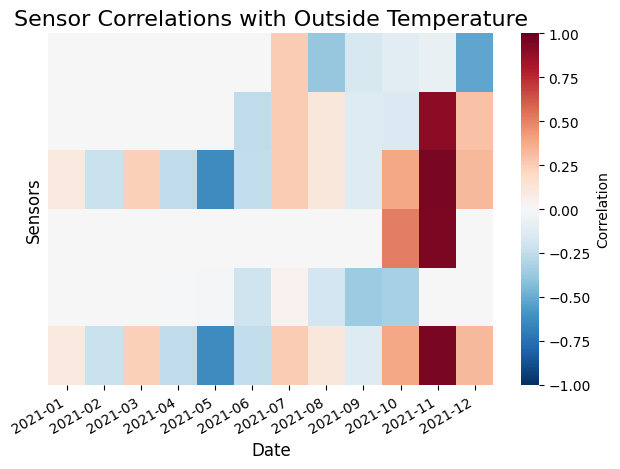

In [79]:
sns.heatmap(result_df[sensor_columns].T, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=result_df['Date'].dt.strftime('%Y-%m'),
            # yticklabels=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6']
            yticklabels=[]
            )

# Customize the plot
plt.title('Sensor Correlations with Outside Temperature', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sensors', fontsize=12)
plt.gcf().autofmt_xdate()
plt.tight_layout()